Для любых видео восстановить траекторию движения (t вектор). Выполнить визуализацию. 
Определить параметры которые влияют на "точность" определения вектора t
Использовать решение на базе нейронных сетей. 
Любые идеи. 

***slam прикрутить. 
Видео 1 но что бы работало. 

In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
def filter_matches_distance(matches, dist_threshold):
    
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)
    
    return filtered_match

In [3]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [4]:
# Отобразить точек
def visualize_matches(image1, kp1, image2, kp2, match):
    
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    cv2.putText(image_matches, str(len(match)), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 7)
    #plt.imshow(image_matches)
    # Убираем оси
    #plt.axis('off')

    # Сохраняем график в файл
    #plt.savefig('plot_without_axes.png', bbox_inches='tight', pad_inches=0)
    return image_matches

In [5]:
cap = cv2.VideoCapture('video.mp4')

def nothing(x):
    pass

#cv2.namedWindow('settings')
#cv2.createTrackbar('k', 'settings', 50, 100, nothing)
#switch = '0 : OFF\n 1 : ON'
#cv2.createTrackbar("On/Off", 'settings', 0, 1, nothing)

K = np.array([[3000 ,   0.    , 960],
             [  0.    , 3000 , 540 ],
            [  0.    ,   0.    ,   1.]], dtype=np.float32)
sift = cv2.SIFT_create()

# Сопоставление особых точек (BFMatcher с нормой Hamming)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

poses = []
# Сохранить позиции камеры
positions = [np.array([0, 0, 0])]

ret_old, frame_old = cap.read()
k = 0.5
i = 1
visualize = frame_old
while True:
    ret, frame = cap.read()
    if not ret:
        break
    
    if i%3 == 0:
                
        #img1 = cv2.imread(image_files[i], cv2.IMREAD_GRAYSCALE)
        #img2 = cv2.imread(image_files[i + 1], cv2.IMREAD_GRAYSCALE)
            
        keypoints1, descriptors1 = sift.detectAndCompute(frame_old, None)
        keypoints2, descriptors2 = sift.detectAndCompute(frame, None)
        
        matches = match_features(descriptors1, descriptors2, matching='BF', detector='sift', sort=True)
        matches = filter_matches_distance(matches, k)
        
        visualize = visualize_matches(frame_old, keypoints1, frame, keypoints2, matches)
        

        pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
        pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)
        
        F, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.LMEDS, prob=0.999, threshold=1.0)     
        
        a, R, t, b = cv2.recoverPose(F, pts1, pts2, K, mask)
        
        poses.append((R, t))

        # Обновить позицию камеры
        current_position = positions[-1]
        new_position = current_position + np.dot(R, t).T[0]
        positions.append(new_position) 
        
        #s = cv2.getTrackbarPos("On/Off", 'settings')
        #if s == 0:
        # pass
        #else:
        #k = cv2.getTrackbarPos('k', 'settings')/100
            
            
        frame_old = frame.copy()
               
    
    #cv2.imshow('frame', frame)
    cv2.imshow('visualize', visualize)
    
    i+=1
    
    if cv2.waitKey(30) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

In [ ]:
F, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.LMEDS, prob=0.999, threshold=1.0)     
       
a, R, t, b = cv2.recoverPose(F, pts1, pts2, K, mask)

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def create_trajectory(poses):
    trajectory = [np.array([0, 0, 0])]
    current_pose = np.eye(4)
    pose_cam = [np.array([[0, 0, 0],[0, 0, 0],[0, 0, 0]])]

    for R, t in poses:
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t.T
        current_pose = np.dot(current_pose, T)
        trajectory.append(current_pose[:3, 3])
        pose_cam.append(current_pose[:3, :3])

    return np.array(trajectory),np.array(pose_cam)

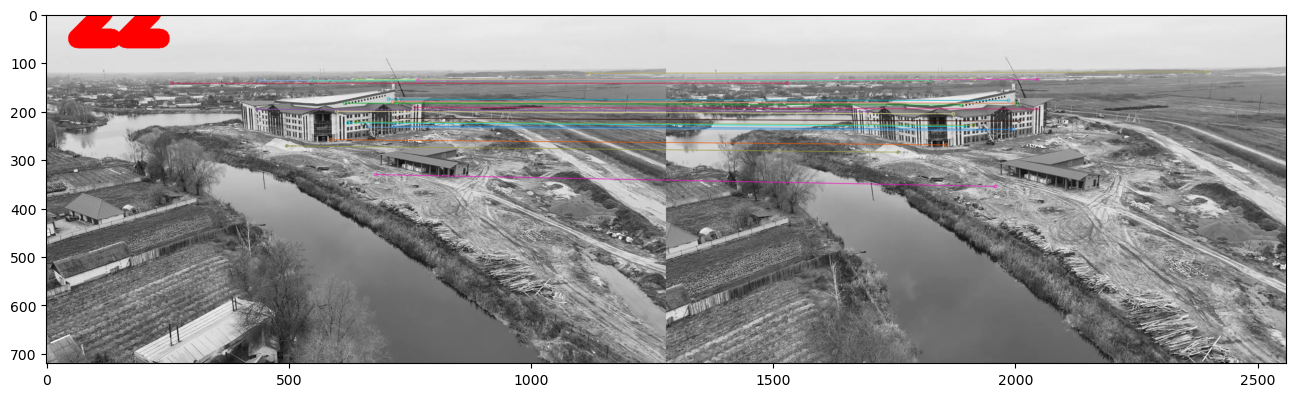

In [25]:
frame_old = cv2.imread("frame_1.jpg", cv2.IMREAD_GRAYSCALE)
frame = cv2.imread("frame_120.jpg", cv2.IMREAD_GRAYSCALE)
 
K = np.array([[3000 ,   0.    , 960],
             [  0.    , 3000 , 540 ],
            [  0.    ,   0.    ,   1.]], dtype=np.float32)
sift = cv2.SIFT_create()

# Сопоставление особых точек (BFMatcher с нормой Hamming)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

poses = []
# Сохранить позиции камеры
positions = [np.array([0, 0, 0])]
         
keypoints1, descriptors1 = sift.detectAndCompute(frame_old, None)
keypoints2, descriptors2 = sift.detectAndCompute(frame, None)

matches = match_features(descriptors1, descriptors2, matching='BF', detector='sift', sort=True)
matches = filter_matches_distance(matches, 0.2)

visualize = visualize_matches(frame_old, keypoints1, frame, keypoints2, matches)


pts1 = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts2 = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

F, mask = cv2.findEssentialMat(pts1, pts2, K, method=cv2.LMEDS, prob=0.999, threshold=1.0)     

a, R, t, b = cv2.recoverPose(F, pts1, pts2, K, mask)

poses.append((R, t))

# Обновить позицию камеры
current_position = positions[-1]
new_position = current_position + np.dot(R, t).T[0]
positions.append(new_position) 
cv2.destroyAllWindows()
plt.imshow(visualize)